In [57]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from lifetimes import BetaGeoFitter, GammaGammaFitter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
ecomm_df = pd.read_excel('NoA-Connect-JrDataScience-Case.xlsx', parse_dates=['order_date'])

In [20]:
ecomm_df.head()

,order_id,purchase_amount,currency,order_date,customer_id
0,06c4bd28-eda3-42df-b819-aa19157a7d45,15.29,EUR,2025-01-22,835ec885-114a-4f7f-b2a4-d7b45dc74411
1,3daaf5f9-b2c2-457a-9abf-330e279fc5c0,37.19,EUR,2025-01-22,74093a26-a976-42f8-b5c1-fcef1faebe9c
2,33e1834f-db37-4a99-9be5-e45886b4dfd4,56.37,EUR,2025-01-22,a27631c8-3fbd-4ace-a46f-c65b2c5928d2
3,0b51225c-0ffe-4b4a-990b-f266f58e51aa,24.19,EUR,2025-01-22,2d5c1cad-07eb-439f-8ffa-9cd8ced6cea2
4,8d635007-5ab8-4680-988a-6ac5a93ea14b,24.79,USD,2025-01-22,48a9bdca-dbf9-41b3-be54-93cf62d257da


In [64]:
ecomm_df['currency'].unique()

array(['EUR', 'USD', 'GBP'], dtype=object)

In [69]:
print(ecomm_df.groupby(['currency'])[['purchase_amount']].sum())

          purchase_amount
currency                 
EUR            2629573.61
GBP              47751.42
USD             268018.47


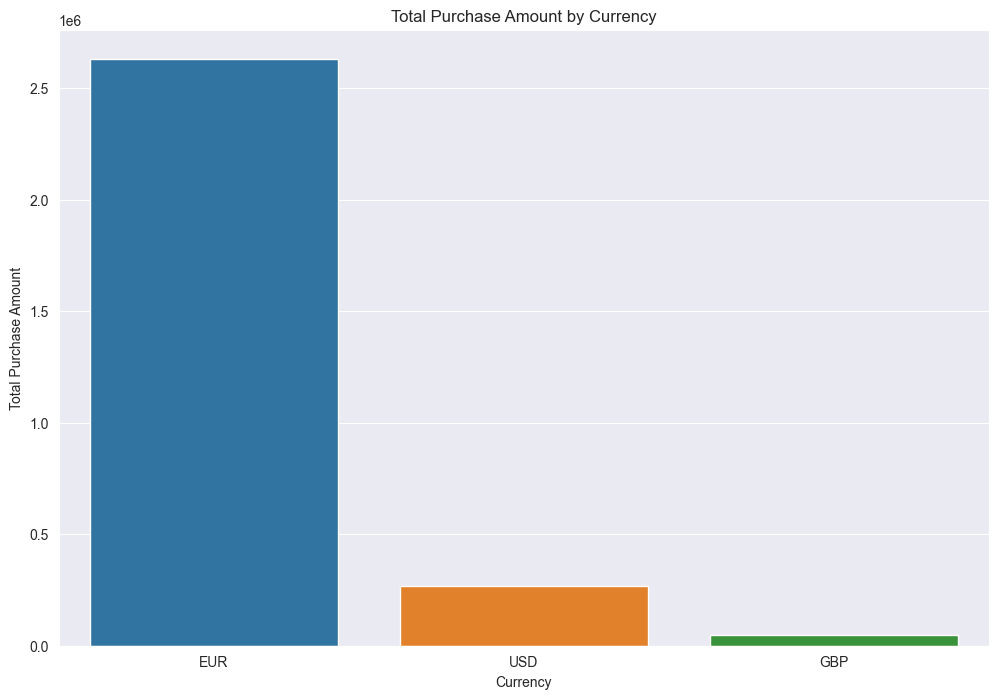

In [128]:
# Sort by total purchase amount per currency 
ecomm_df_curr = ecomm_df.groupby("currency", as_index=False)["purchase_amount"].sum().sort_values(by="purchase_amount", ascending=False)

# Set plot style
sns.set_style('darkgrid')

# Create figure and axis
plt.figure(figsize=(12, 8))

# Create barplot
sns.barplot(data=ecomm_df_curr, x="currency", y="purchase_amount", hue="currency")

# Improve labeling
plt.xlabel("Currency")
plt.ylabel("Total Purchase Amount")
plt.title("Total Purchase Amount by Currency")

# Show plot
plt.show()


In [132]:
ecomm_df.describe()

,purchase_amount,order_date
count,51948.000000,51948
mean,56.697919,2024-05-30 02:21:20.665280768
min,0.000000,2023-01-01 00:00:00
25%,17.140000,2024-02-19 00:00:00
50%,25.190000,2024-06-21 00:00:00
75%,41.980000,2024-10-06 00:00:00
max,13976.400000,2025-01-22 00:00:00
std,207.860065,NaN


In [130]:
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51948 entries, 0 to 51947
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         51948 non-null  object        
 1   purchase_amount  51948 non-null  float64       
 2   currency         51948 non-null  object        
 3   order_date       51948 non-null  datetime64[ns]
 4   customer_id      51948 non-null  object        
 5   order_month      51948 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), object(3), period[M](1)
memory usage: 2.4+ MB


In [131]:
ecomm_df.shape

(51948, 6)

In [133]:
# Group orders by month for simpler graph
ecomm_df['order_month'] = ecomm_df['order_date'].dt.to_period('M')
monthly_df = ecomm_df.groupby(['order_month', 'currency'], as_index=False)['purchase_amount'].sum()
monthly_df['order_month'] = monthly_df['order_month'].astype(str)

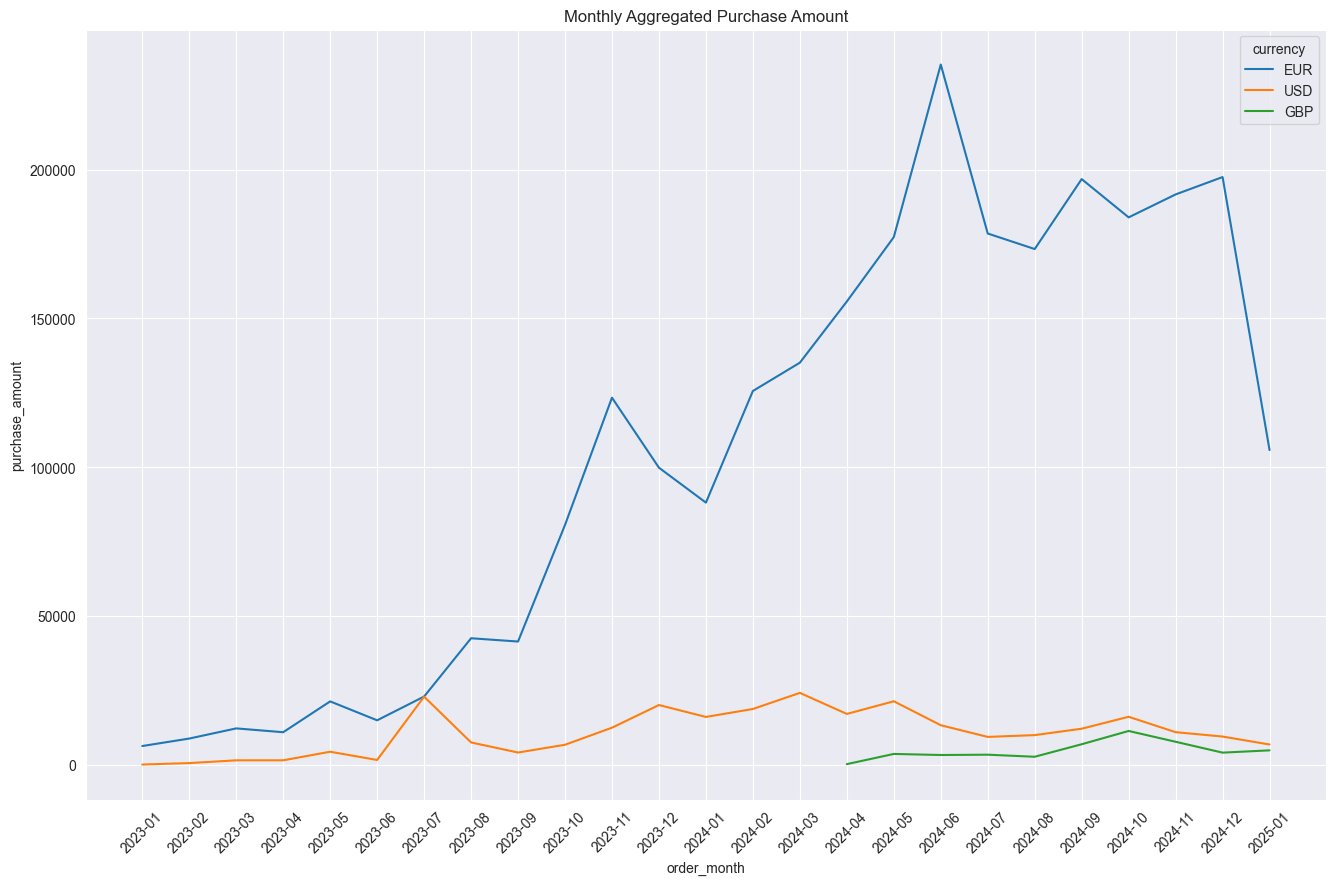

In [134]:
plt.figure(figsize=(16,10))
sns.lineplot(x="order_month", y="purchase_amount",
             hue="currency",
             data=monthly_df)

plt.xticks(rotation=45)
plt.title("Monthly Aggregated Purchase Amount")
plt.show()

In [135]:
login_counts = ecomm_df['customer_id'].value_counts()
single_logins = (login_counts == 1).sum()
print("The number of single logins are:", single_logins)

The number of single logins are: 4505


In [136]:
ecomm_df.nunique()

order_id           51948
purchase_amount     7067
currency               3
order_date           750
customer_id         7373
order_month           25
dtype: int64

In [137]:
big_spenders = ecomm_df[ecomm_df['purchase_amount'] > 8000]['customer_id'].unique()
print(big_spenders)

['a01b746c-88c9-45e2-ad7a-6ef25d10c7d8'
 '9e4062c6-2573-4d82-b0c6-f9f29978dc9e'
 '919cdf1c-443c-495c-b2de-f96cdd121a71']


In [176]:
# Aggregate to customer level
clv_data = ecomm_df.groupby('customer_id').agg(
    frequency=('order_id', 'count'),  # Number of repeat purchases
    recency=('order_date', lambda x: (x.max() - x.min()).days),  # Days between first & last purchase
    T=('order_date', lambda x: (ecomm_df['order_date'].max() - x.min()).days),  # Customer's age (days)
    monetary_value=('purchase_amount', 'mean')  # Average order value
).reset_index()

In [160]:
clv_data.head()

,customer_id,frequency,recency,T,monetary_value
0,00235c62-e617-4eb0-a050-470c9f30e87f,1,0,441,26.990000
1,00341635-2bff-4605-b3d0-ea405649659d,3,301,308,90.016667
2,003fb56f-aa7f-4dd9-83bd-2209bb1076d4,1,0,224,129.520000
3,004c365f-ed0a-4287-af51-77c29fc32803,2,48,176,30.275000
4,004db925-5b13-4cf3-baac-df11e6e9b04b,2,16,219,59.600000


In [141]:
print(clv_data.isnull().sum())

customer_id       0
frequency         0
recency           0
T                 0
monetary_value    0
dtype: int64


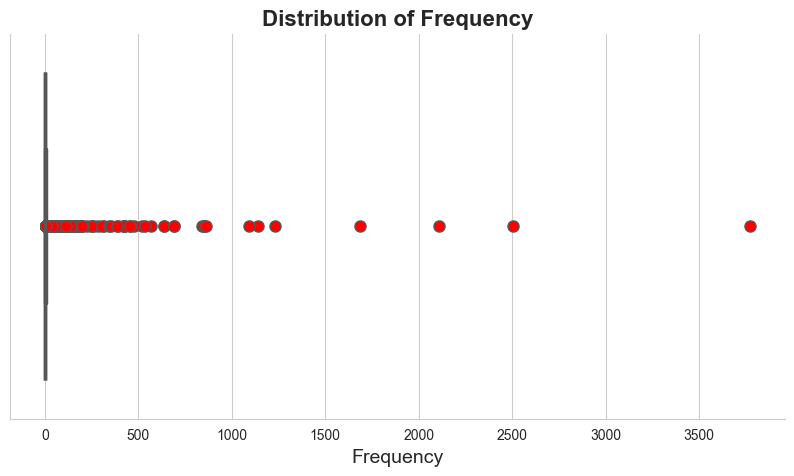

In [143]:
# Set style
sns.set_style("whitegrid")  
plt.figure(figsize=(10, 5))  # Increase figure size

# Create the boxplot
ax = sns.boxplot(
    data=clv_data, 
    x='frequency', 
    color='royalblue', 
    linewidth=2.5,  
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8}  # Style outliers
)

# Add title and labels
ax.set_title("Distribution of Frequency", fontsize=16, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)

# Remove top and right spines for a cleaner look
sns.despine()

plt.show()


In [182]:
# Filter out first-time customers (BG/NBD requires at least one repeat purchase)
clv_data = clv_data[clv_data['frequency'] > 1]

In [183]:
clv_data['T'] = clv_data['T'].clip(upper=clv_data['T'].quantile(0.95))  # Cap at the 95th percentile
clv_data = clv_data[clv_data['recency'] <= clv_data['T']]


In [184]:
clv_data['monetary_value'] = np.log1p(clv_data['monetary_value'])


In [188]:
# Fit BG/NBD model (predicts future transactions)
bgf = BetaGeoFitter()
bgf.fit(clv_data['frequency'], clv_data['recency'], clv_data['T'])

<lifetimes.BetaGeoFitter: fitted with 2834 subjects, a: 1.09, alpha: 3.53, b: 4.72, r: 0.56>

In [190]:
print(clv_data[clv_data['monetary_value'] <= 0])


                               customer_id  frequency  recency    T  \
4046  8931dde7-9950-493b-8865-25e09d14eeb4          4       41  244   

      monetary_value  
4046             0.0  


In [191]:
clv_data = clv_data[clv_data['monetary_value'] > 0]


In [192]:
# Fit Gamma-Gamma model (predicts monetary value per purchase)
ggf = GammaGammaFitter()
ggf.fit(clv_data['frequency'], clv_data['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2833 subjects, p: 57.24, q: 159.56, v: 4.48>

In [193]:
# Predict CLV
clv_data['CLV'] = ggf.customer_lifetime_value(
    bgf,  
    clv_data['frequency'], 
    clv_data['recency'], 
    clv_data['T'], 
    clv_data['monetary_value'], 
    time=12,  
    freq="D",  
    discount_rate=0.01  
)

print(clv_data[['customer_id', 'CLV']].head())

                            customer_id       CLV
1  00341635-2bff-4605-b3d0-ea405649659d  4.224614
3  004c365f-ed0a-4287-af51-77c29fc32803  0.936819
4  004db925-5b13-4cf3-baac-df11e6e9b04b  0.048109
5  0052d0bb-94f7-47b4-ad1f-ae1f03bfe005  6.435082
6  0054705a-66d4-4d5f-8d6c-0abc2655f800  0.005359


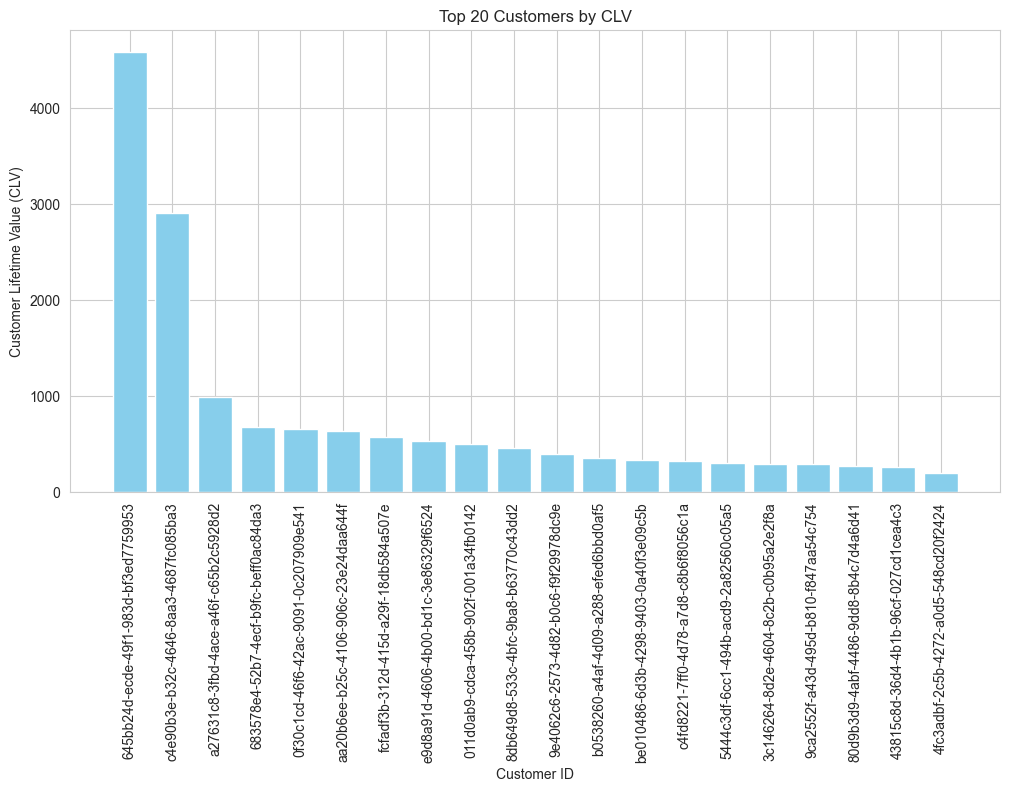

In [194]:
# Sort by CLV and take top 20 customers
top_customers = clv_data.nlargest(20, 'CLV')

plt.figure(figsize=(12, 6))
plt.bar(top_customers['customer_id'], top_customers['CLV'], color='skyblue')
plt.xticks(rotation=90)  # Rotate customer IDs for readability
plt.xlabel("Customer ID")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.title("Top 20 Customers by CLV")
plt.show()

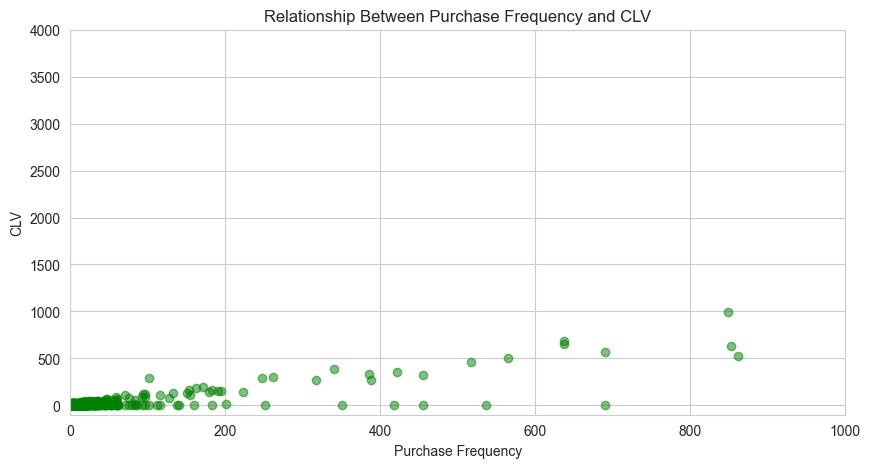

In [195]:
plt.figure(figsize=(10, 5))
plt.scatter(clv_data['frequency'], clv_data['CLV'], alpha=0.5, color='green')
plt.xlabel("Purchase Frequency")
plt.ylabel("CLV")
plt.title("Relationship Between Purchase Frequency and CLV")
# Set limits
plt.xlim(0, 1000)  # X-axis limit (Frequency)
plt.ylim(-100, 4000)  # Y-axis limit (CLV)
plt.show()

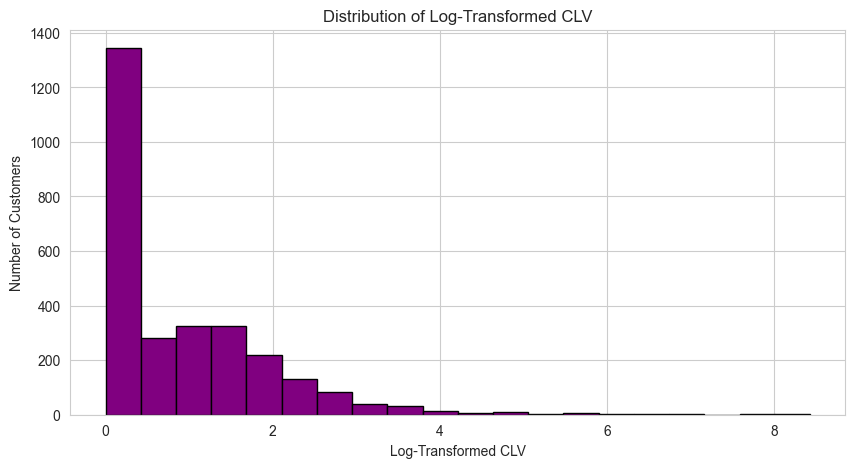

In [197]:
# Apply log transformation (add 1 to avoid log(0) issues)
clv_data['log_CLV'] = np.log1p(clv_data['CLV'])

# Plot histogram of log-transformed CLV
plt.figure(figsize=(10, 5))
plt.hist(clv_data['log_CLV'], bins=20, color='purple', edgecolor='black')
plt.xlabel("Log-Transformed CLV")
plt.ylabel("Number of Customers")
plt.title("Distribution of Log-Transformed CLV")
plt.show()
